In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re
color = sns.color_palette()

%matplotlib inline

In [2]:
from subprocess import check_output
print(check_output(["ls", "../Data"]).decode("utf8"))

stage1_solution_filtered.csv.7z
stage_2_private_solution.csv.7z
stage2_sample_submission.csv.7z
stage2_test_text.csv.7z
stage2_test_variants.csv.7z
test_text
test_text.zip
test_variants
test_variants.zip
training_text
training_text.zip
training_variants
training_variants.zip



In [3]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [4]:
training_variants_df = pd.read_csv("../Data/training_variants")
training_variants_df.head(5)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
print(training_variants_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB
None


In [6]:
(training_variants_df['Gene'].nunique())

264

In [7]:
(training_variants_df['Variation'].nunique())

2996

In [8]:
test_variants_df = pd.read_csv("../Data/test_variants")
test_variants_df.head(5)

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


In [9]:
test_variants_df.shape

(5668, 3)

In [10]:
training_text_df = pd.read_csv("../Data/training_text",sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
training_text_df.head(5)

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [11]:
test_text_df = pd.read_csv("../Data/test_text",sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text_df.head(5)

,ID,Text
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [12]:
training_df = training_variants_df.merge(training_text_df, left_on="ID",right_on="ID")
training_df.head(5)

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64


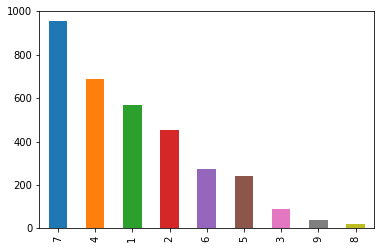

In [13]:
print(training_df['Class'].value_counts())
training_df['Class'].value_counts().plot(kind='bar')

In [14]:
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /home/ankit/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/ankit/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [17]:
for text in training_df['Text']:
    text = re.sub(r'[^a-zA-Z0-9\w\s+]', " ", str(text))
    

# This is for tokenizing words, removing duplicate words, removing stop words
for i in range(0,len(training_df['Text'])):
    words = nltk.word_tokenize(str(training_df['Text'][i]))
    ordered_tokens = set()
    new_word = []
    new_text = []
    
    for word in words:
        if word.lower() not in ordered_tokens:
            ordered_tokens.add(word.lower())
            new_word.append(word)
    
    for word in new_word:
        if word.lower() not in stopwords.words('english'):
              new_text.append(word)
    
    text = ""
    
    for word in new_text:
        text += " " + word
    
    training_df['Text'][i] = text

In [25]:
text_length = []
for x in training_df['Text']:
    x = len(str(x))
    text_length.append(x)
training_df['text_length'] = text_length

In [26]:
training_df.head(5)

,ID,Gene,Variation,Class,Text,text_length
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,39672
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,36691
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,36691
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,36238
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,41308


In [29]:
Filtered_Text = []
for i in range(0,len(training_df['Text'])):
    words = nltk.word_tokenize(str(training_df['Text'][i]))
    ordered_tokens = set()
    new_word = []
    new_text = []
    
    for word in words:
        if word.lower() not in ordered_tokens:
            ordered_tokens.add(word.lower())
            new_word.append(word)
    
    for word in new_word:
        if word.lower() not in stopwords.words('english'):
              new_text.append(word)
    
    text = ""
    
    for word in new_text:
        text += " " + word
    
    Filtered_Text.append(text)

In [30]:
training_df['Filtered_text'] = Filtered_Text

In [34]:
training_df.tail(5)

,ID,Gene,Variation,Class,Text,text_length,Filtered_text
3316,3316,RUNX1,D171N,4,Introduction Myelodysplastic syndromes (MDS) ...,73895,Introduction Myelodysplastic syndromes ( MDS ...
3317,3317,RUNX1,A122*,1,Introduction Myelodysplastic syndromes (MDS) ...,40127,Introduction Myelodysplastic syndromes ( MDS ...
3318,3318,RUNX1,Fusions,1,The Runt-related transcription factor 1 gene (...,36200,Runt-related transcription factor 1 gene ( RU...
3319,3319,RUNX1,R80C,4,The RUNX1/AML1 gene is the most frequent targe...,32520,RUNX1/AML1 gene frequent target chromosomal t...
3320,3320,RUNX1,K83E,4,The most frequent mutations associated with le...,67136,frequent mutations associated leukemia recurr...


In [35]:
filtered_text_length = []
for x in training_df['Filtered_text']:
    x = len(x)
    filtered_text_length.append(x)
training_df['filtered_text_length'] = filtered_text_length

In [36]:
training_df.head(5)

,ID,Gene,Variation,Class,Text,text_length,Filtered_text,filtered_text_length
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,39672,Cyclin-dependent kinases ( CDKs ) regulate va...,12258
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,36691,Abstract Background Non-small cell lung cance...,11179
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,36691,Abstract Background Non-small cell lung cance...,11179
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,36238,Recent evidence demonstrated acquired unipare...,11518
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,41308,Oncogenic mutations monomeric Casitas B-linea...,11868


In [37]:
UpperCase_Text = []
for i in range(0,len(training_df['Filtered_text'])):
    words = nltk.word_tokenize(str(training_df['Filtered_text'][i]))
    ordered_tokens = set()
    new_word = []
    new_text = []
    
    for word in words:
        if word == word.upper() and word not in ordered_tokens:
            ordered_tokens.add(word)
            new_word.append(word)
    
    text = ""
    
    for word in new_word:
        text += " " + word
    
    UpperCase_Text.append(text)

In [38]:
training_df['UpperCase_Text'] = UpperCase_Text

In [39]:
training_df.head(10)

,ID,Gene,Variation,Class,Text,text_length,Filtered_text,filtered_text_length,UpperCase_Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,39672,Cyclin-dependent kinases ( CDKs ) regulate va...,12258,"( ) . CDK10 ETS2 E26 2 MAPK , FAM58A STAR 1 2..."
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,36691,Abstract Background Non-small cell lung cance...,11179,"( NSCLC ) . E3 , EGFR MET FFPE DNA ; KRAS LOH..."
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,36691,Abstract Background Non-small cell lung cance...,11179,"( NSCLC ) . E3 , EGFR MET FFPE DNA ; KRAS LOH..."
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,36238,Recent evidence demonstrated acquired unipare...,11518,"( ) . , SNP 58 ; = 30 JAK2 MF 18 PV 10 33 % 1..."
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,41308,Oncogenic mutations monomeric Casitas B-linea...,11868,"( ) , . E2 EGFR CBL-E2 : ; 1 2 3 4 RING E3 5 ..."
5,5,CBL,V391I,4,Oncogenic mutations in the monomeric Casitas B...,41308,Oncogenic mutations monomeric Casitas B-linea...,11868,"( ) , . E2 EGFR CBL-E2 : ; 1 2 3 4 RING E3 5 ..."
6,6,CBL,V430M,5,Oncogenic mutations in the monomeric Casitas B...,41308,Oncogenic mutations monomeric Casitas B-linea...,11868,"( ) , . E2 EGFR CBL-E2 : ; 1 2 3 4 RING E3 5 ..."
7,7,CBL,Deletion,1,CBL is a negative regulator of activated recep...,98867,CBL negative regulator activated receptor tyr...,22991,"CBL ( RTK ) . , : 300 AML MDS 82 RING 3 279 A..."
8,8,CBL,Y371H,4,Abstract Juvenile myelomonocytic leukemia (JM...,79774,Abstract Juvenile myelomonocytic leukemia ( J...,18042,"( JMML ) GM-CSF . SHP2 , NF-1 KRAS NRAS RAS C..."
9,9,CBL,C384R,4,Abstract Juvenile myelomonocytic leukemia (JM...,38465,Abstract Juvenile myelomonocytic leukemia ( J...,9136,"( JMML ) GM-CSF . SHP2 , NF-1 KRAS NRAS RAS C..."


In [41]:
cap_text_length = []
for x in training_df['UpperCase_Text']:
    x = len(x)
    cap_text_length.append(x)
training_df['cap_text_length'] = cap_text_length

In [1]:
training_df.tail(10)

NameError: name 'training_df' is not defined